## **Implementation on Bipartite Graph**

> To address the limitation of the knowledge graph on clustering each document based on their meaning, we will follow these steps:  

1. **Document/Entity Graph:**
   - **Entity Extraction:** extract keywords from each document
   - **Node Representation:** create bipartitte graph where one set of node consist of document representation and another set of node represent all keyword  


2. **Entity-Entity Graph:**
   - **Multiple Relationships:** then we start to project bipartite graph onto a set of keyword node to understand their relationship within keyword.  

3. **Filtering the Graph (Be aware of Dimension):**
   - due to many node and edges, we will need to filter for better analysis.  

4. **Analyzing the Graph:**
   - After we filter the graph relationship, then we are better able to visualize the relationship within the entity.

5. **Document-Document Graph:**
   - then we will repeat the step on analysis on entity-entity relationship in other to analyse on document document relationship


### **1. Bipartite Document-Entity Graph**  
> The term `"relevant entity"` is somewhat define a relevant entity as either a named entity (like an organization, person, or location recognized by the **NER engine**) or a keyword. Essentially, it's a **word or combination of words that identifies and generally describes the document and its content.**  
  
> Various algorithms can be employed to extract keywords from a document. One such method is `TF-IDF` (Term Frequency-Inverse Document Frequency) score. TF-IDF assigns a score to each word based on how often it appears in a specific document and how unique it is across the entire set of documents and `IDF` (the Inverse Document Frequency) considers the inverse frequency of a word across the entire corpus :

$$
\frac {C_{ij}}{\sum_{C_{ij}}}  * \log{N \over (1 + D_i)}
$$  
- $C_{ij}$ represents the count of the word i in document j.  
- $N$ is the total number of documents in the corpus.  
- $D_i$ is the document where the word i appears.  
  
> The `TF-IDF` score is designed to highlight words that are frequently repeated within a document while downplaying common words that might not be very distinctive.

> Another method that is more better than TF-IDF is `TextRank`. **But how does TextRank Operate?**  
  
- TextRank operates by **creating a network representation of a document based on a graph**. In this graph, individual words (tokens) serve as nodes, and edges are formed between them if the words are found within a specific window of each other.  

- Once this network is established, TextRank applies the `PageRank algorithm` to calculate the **centrality of each token**. Centrality is a measure of importance of a node within the document, and PageRank assigns a score to each token, allowing for ranking based on this centrality score. The tokens with the highest centrality, typically within a certain percentage range (commonly between 5% and 20% of the document size), are recognized as candidate keywords.  
  
- When candidate keywords are in close proximity to each other, TextRank combines them into composite keywords, consisting of multiple tokens.  
  
- Implementations of TextRank are available in many NLP packages. One such package is `gensim`

In [1]:
# import nltk
# nltk.download('reuters')

In [2]:
from nltk.corpus import reuters
import pandas as pd
from langdetect import detect
import numpy as np
import spacy
import re

corpus = pd.DataFrame([
    {"id": _id,
     "text": reuters.raw(_id).replace("\n", ""), 
     "label": reuters.categories(_id)}
    for _id in reuters.fileids()
 ])
# corpus = corpus.loc[:4]

# Clean the Text
def clean_text(text):
    # Remove escape characters
    text = text.replace("\n", "")
    # Convert to lowercase
    text = text.lower()
    # Remove quotes around company names
    text = re.sub(r'<(.*?)>', r'\1', text)
    return text
corpus['clean_text']=corpus["text"].apply(clean_text)
# corpus["clean_text"] = corpus["text"].apply(
#     lambda x: x.replace("\n", "")
#  )

#Detect Language within Each Article of dataset
def getLanguage(text: str):
    try:
        return detect(text)
    except:
        return np.nan
corpus["language"] = corpus["text"].apply(detect)

# load the model NLP and apply to the clean text
nlp = spacy.load('en_core_web_md')
corpus["parsed"] = corpus["clean_text"]\
.apply(nlp)




> each keyword was extracting from gensim by using `TF-IDF score` algorithm, TF-IDF score promotes words that are repeated many times in the document, penalizing words that are common and therefore might not be very representative for a document.

In [3]:
from gensim.summarization import keywords

text = corpus["clean_text"][0]
extracted_keywords = keywords(text, words=10, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True)

extracted_keywords


[('trading', 0.4615130639538527),
 ('said', 0.315985569349451),
 ('export', 0.2691553824958071),
 ('import', 0.1746201000645691),
 ('japanese electronics', 0.13609326263790256),
 ('industry', 0.12860437403797764),
 ('minister', 0.12229815662000443),
 ('japan', 0.11434500812642323),
 ('year', 0.10483992409352486)]

> The purpose of this line of code is to extract the top 10 keywords from the input text (text) while considering their scores, part-of-speech, and applying lemmatization. The result (extracted_keywords) is a list of tuples, where each tuple contains a keyword and its associated score.  
- `pos_filter`=('NN', 'JJ'): This parameter filters the extracted keywords based on their part-of-speech (POS). Here, it includes nouns (NN) and adjectives (JJ).  
- `scores`=True: This parameter, when set to True, causes the keywords function to return a list of tuples where each tuple contains a keyword and its score.  
> Here, the score represents the `centrality,` **which represents the importance of a given token**. As you can see, some composite tokens may also occur, such as japanese
electronics. Keyword extraction can be implemented to compute the keywords for
the entire corpus, thus storing the information in our corpus DataFrame:

In [4]:
##include keywords by taking only top 10 within or less 
# keywordsCorpus=[]
# for text in corpus["clean_text"]:
#     try:
#         extracted_keywords = keywords(text, words=10, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True)
#         keywordsCorpus.append(extracted_keywords)
#     except Exception as e:
#         extracted_keywords = keywords(text, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True)
#         keywordsCorpus.append(extracted_keywords)



#corpus['keywords']=keywordsCorpus


In [5]:
corpus['keywords'] = corpus["clean_text"].apply(lambda text: keywords(text, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True))
corpus.head()


,id,text,label,clean_text,language,parsed,keywords
0,test/14826,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,[trade],asian exporters fear damage from u.s.-japan ri...,en,"(asian, exporters, fear, damage, from, u.s.-ja...","[(trading, 0.4615130639538533), (said, 0.31598..."
1,test/14828,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,[grain],china daily says vermin eat 7-12 pct grain sto...,en,"(china, daily, says, vermin, eat, 7, -, 12, pc...","[(vermin, 0.31206143802871716), (daily, 0.2611..."
2,test/14829,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[crude, nat-gas]",japan to revise long-term energy demand downwa...,en,"(japan, to, revise, long, -, term, energy, dem...","[(energy demand, 0.3668609094700035), (nuclear..."
3,test/14832,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,"[corn, grain, rice, rubber, sugar, tin, trade]",thai trade deficit widens in first quarter th...,en,"(thai, trade, deficit, widens, in, first, quar...","[(pct, 0.5457455609144314), (export, 0.2656069..."
4,test/14833,INDONESIA SEES CPO PRICE RISING SHARPLY Indon...,"[palm-oil, veg-oil]",indonesia sees cpo price rising sharply indon...,en,"(indonesia, sees, cpo, price, rising, sharply,...","[(indonesia, 0.24104282355029363), (harahap, 0..."


In [6]:
def extractEntities(ents, minValue=1, typeFilters=["GPE", "ORG", "PERSON"]):
    entities = pd.DataFrame([
        {
            "lemma": e.lemma_,
            "lower": e.lemma_.lower(),
            "type": e.label_
        } for e in ents if hasattr(e, "label_")
    ])
    if len(entities) == 0:
        return pd.DataFrame()
    g = entities.groupby(["type", "lower"])
    summary = pd.concat({
        "alias": g.apply(lambda x: x["lemma"].unique()),
        "count": g["lower"].count()
    }, axis=1)
    
    # Use boolean indexing to filter rows based on typeFilters
    filtered_summary = summary[summary["count"] > minValue]
    filtered_summary = filtered_summary[filtered_summary.index.get_level_values('type').isin(typeFilters)]
    
    return filtered_summary

def getOrEmpty(parsed, _type):
    try:
        return list(parsed.loc[_type]["count"]\
            .sort_values(ascending=False).to_dict().items())
    except:
        return []

def toField(ents):
    typeFilters = ["GPE", "ORG", "PERSON"]
    parsed = extractEntities(ents, 1, typeFilters)
    return pd.Series({_type: getOrEmpty(parsed, _type)
                      for _type in typeFilters})

> Besides the keywords, to build the bipartite graph, we also need **to parse the named entities that were extracted by the NER engine**, and then encode the information in a similar data format as the one that was used for the keywords.  
  
> These function just take each parsed from each text and find out the type of entities within each text where we filter for only type **Location, Organiation and Person**

In [7]:
entities = corpus["parsed"].apply(lambda x: toField(x.ents))

In [8]:
entities

,GPE,ORG,PERSON
0,"[(u.s., 17), (japan, 12), (taiwan, 3), (austra...",[],[]
1,"[(china, 2)]",[],[]
2,"[(japan, 2)]","[(miti, 3)]",[]
3,"[(thailand, 2)]",[],[]
4,"[(indonesia, 4), (malaysia, 2)]",[],[]
...,...,...,...
10783,[],[],[]
10784,[],[],[]
10785,[],[],[]
10786,[],[],[]


In [9]:
merged = pd.concat([corpus, entities], axis=1)
merged

,id,text,label,clean_text,language,parsed,keywords,GPE,ORG,PERSON
0,test/14826,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,[trade],asian exporters fear damage from u.s.-japan ri...,en,"(asian, exporters, fear, damage, from, u.s.-ja...","[(trading, 0.4615130639538533), (said, 0.31598...","[(u.s., 17), (japan, 12), (taiwan, 3), (austra...",[],[]
1,test/14828,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,[grain],china daily says vermin eat 7-12 pct grain sto...,en,"(china, daily, says, vermin, eat, 7, -, 12, pc...","[(vermin, 0.31206143802871716), (daily, 0.2611...","[(china, 2)]",[],[]
2,test/14829,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[crude, nat-gas]",japan to revise long-term energy demand downwa...,en,"(japan, to, revise, long, -, term, energy, dem...","[(energy demand, 0.3668609094700035), (nuclear...","[(japan, 2)]","[(miti, 3)]",[]
3,test/14832,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,"[corn, grain, rice, rubber, sugar, tin, trade]",thai trade deficit widens in first quarter th...,en,"(thai, trade, deficit, widens, in, first, quar...","[(pct, 0.5457455609144314), (export, 0.2656069...","[(thailand, 2)]",[],[]
4,test/14833,INDONESIA SEES CPO PRICE RISING SHARPLY Indon...,"[palm-oil, veg-oil]",indonesia sees cpo price rising sharply indon...,en,"(indonesia, sees, cpo, price, rising, sharply,...","[(indonesia, 0.24104282355029363), (harahap, 0...","[(indonesia, 4), (malaysia, 2)]",[],[]
...,...,...,...,...,...,...,...,...,...,...
10783,training/999,U.K. MONEY MARKET SHORTAGE FORECAST REVISED DO...,"[interest, money-fx]",u.k. money market shortage forecast revised do...,en,"(u.k, ., money, market, shortage, forecast, re...","[(market, 0.3364640504513775), (forecast, 0.33...",[],[],[]
10784,training/9992,KNIGHT-RIDDER INC &lt;KRN> SETS QUARTERLY Qtl...,[earn],knight-ridder inc &lt;krn> sets quarterly qtl...,en,"(knight, -, ridder, inc, &, lt;krn, >, sets, q...","[(april, 0.3308634968522971), (sets, 0.3308634...",[],[],[]
10785,training/9993,TECHNITROL INC &lt;TNL> SETS QUARTERLY Qtly d...,[earn],technitrol inc &lt;tnl> sets quarterly qtly d...,en,"(technitrol, inc, &, lt;tnl, >, sets, quarterl...","[(april, 0.47842480045583435), (sets, 0.336643...",[],[],[]
10786,training/9994,NATIONWIDE CELLULAR SERVICE INC &lt;NCEL> 4TH ...,[earn],nationwide cellular service inc &lt;ncel> 4th ...,en,"(nationwide, cellular, service, inc, &, lt;nce...","[(shrs, 0.48295618305740917), (loss, 0.4437435...",[],[],[]


> Now for all the incredient we got, we can build the bipartite graph now.

In [10]:
for id, row in merged.iterrows():
    print(id, row)
    break;

0 id                                                   test/14826
text          ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...
label                                                   [trade]
clean_text    asian exporters fear damage from u.s.-japan ri...
language                                                     en
parsed        (asian, exporters, fear, damage, from, u.s.-ja...
keywords      [(trading, 0.4615130639538533), (said, 0.31598...
GPE           [(u.s., 17), (japan, 12), (taiwan, 3), (austra...
ORG                                                          []
PERSON                                                       []
Name: 0, dtype: object


In [11]:
edges = pd.DataFrame([
{"source": _id, "target": keyword, "weight": score, "type":
_type}
for _id, row in merged.iterrows()
for _type in ["keywords", "GPE", "ORG", "PERSON"]
for (keyword, score) in row[_type]
])

In [12]:
edges

,source,target,weight,type
0,0,trading,0.461513,keywords
1,0,said,0.315986,keywords
2,0,export,0.269155,keywords
3,0,import,0.174620,keywords
4,0,japanese electronics,0.136093,keywords
...,...,...,...,...
70824,10785,sets,0.336644,keywords
70825,10786,shrs,0.482956,keywords
70826,10786,loss,0.443744,keywords
70827,10787,net,0.354102,keywords


> **List Comprehension to Create Rows in edges DataFrame:**  
- For each combination of` _id, _type, and (keyword, score)` in the nested loops, a dictionary is created with keys **"source", "target", "weight", and "type"**.  
- The values for these keys are:  
    - _id (source node)  
    - keyword (target node)  
    - score (weight of the edge)  
    - _type (type of the edge)

In [13]:
import networkx as nx

# Assuming 'edges' is a DataFrame with columns 'source' and 'target'
G = nx.Graph()

# Add nodes with bipartite attribute
G.add_nodes_from(edges["source"].unique(), bipartite=0) #1st set -- Document
G.add_nodes_from(edges["target"].unique(), bipartite=1) #2nd set -- Keywords of Texts

# Add edges
G.add_edges_from([(row["source"], row["target"]) for _, row in edges.iterrows()])

# Overview of the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())



Number of nodes: 23559
Number of edges: 67790
Average degree: 5.754913196655206


> **Source** here represent the index of text so it represent an article or document.  
> **Target** hrer represent all of the Keywords within the text.  
> In the next part, We'll project bipartite graph that has two set of node and that where one is entities and another is the document. This will help us to understand between graph cluster both the terms (words or concepts) and document using unsupervised techniques. 


### **2.Entity-Entity Graph**  


> Before performing projection, we must extract the nodes relative to a **particular set (either documents or entities)** using the "bipartite" property we created when we generated the graph:

In [14]:
document_nodes = {n
        for n, d in G.nodes(data=True)
        if d["bipartite"] == 0}
entity_nodes = {n
        for n, d in G.nodes(data=True)
        if d["bipartite"] == 1}

In [15]:
projected_graph = nx.algorithms.bipartite.projection.projected_graph(G, entity_nodes)
print(projected_graph)


Graph with 12863 nodes and 262365 edges


In [16]:
weighted_entity_projection = nx.algorithms.bipartite.weighted_projected_graph(G, entity_nodes)


> We 2 set of node where one set is document represent and another is entities. 
> The code take the bipartite graph that being made above and seperate it into two set of nodees(documents and entities), then project the graph onto the set of entity nodes, creating new graph that show connection between entities **based on their shared relationship within the document.**

> Next We will use`overlap_weighted_projected_graph`, where the edge weight is computed using the `Jaccard similarity` based on common neighbors

### **3. Be aware of dimension - filering the graph (For Entity-Entity Relationship)**

- It hard to analyst when projecting the bipartite graph to all of entities graph. so we need to filter this graph to reduce this complexity `by only only consider entity nodes that have a certain degree`.
-  Most of the complexity arises from the presence of entities that appear only once or a few times, Besides, they are possibly strongly affected by statistical variability.  
- Moreover, we should focus on **strong correlations** that are supported by larger occurrences and provide more reliable statistical results.

In [17]:
components = nx.connected_components(projected_graph)
pd.DataFrame([len(c) for c in components], columns=['Number Of Node in Entities-Entities'])

,Number Of Node in Entities-Entities
0,12730
1,1
2,3
3,1
4,2
...,...
91,1
92,1
93,1
94,1


In [18]:
nodes_with_low_degree = {n 
 for n, d in nx.degree(G, nbunch=entity_nodes) if d<5}
subGraph = G.subgraph(set(G.nodes) - nodes_with_low_degree)
print(subGraph)

Graph with 12600 nodes and 52115 edges


> This allow the **filter out rare entities** that appear only in few document but the resulting graph could also be affected by the opposite problem: popular entities may be connected just because they tend to appear often in documents, even if there is not an interesting causal connection between them.

In [19]:
#this entity graph take from sub graph that being filter on degree > 5 only
entityGraph = nx.algorithms.bipartite.projection.overlap_weighted_projected_graph(
 subGraph,
 {n for n in subGraph.nodes() if n in entity_nodes}
)
print(entityGraph)

Graph with 1904 nodes and 115650 edges


In [20]:
print("=====EntityGraph=====")
print("Number of nodes:", entityGraph.number_of_nodes())
print("Number of edges:", entityGraph.number_of_edges())
print("Average degree:", sum(dict(entityGraph.degree()).values()) / entityGraph.number_of_nodes())

=====EntityGraph=====
Number of nodes: 1904
Number of edges: 115650
Average degree: 121.48109243697479


> The average degree of the entity graph is too high here. Let look to its distribution

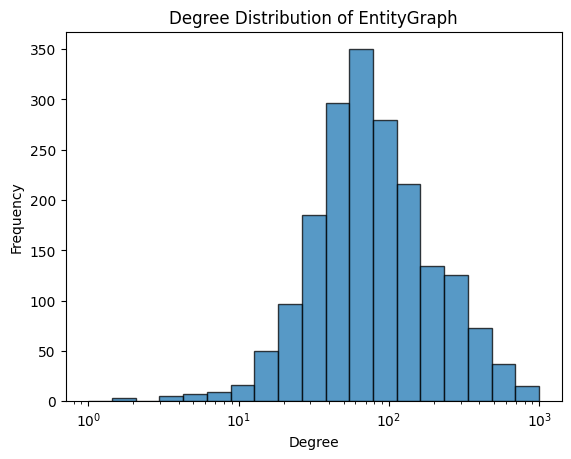

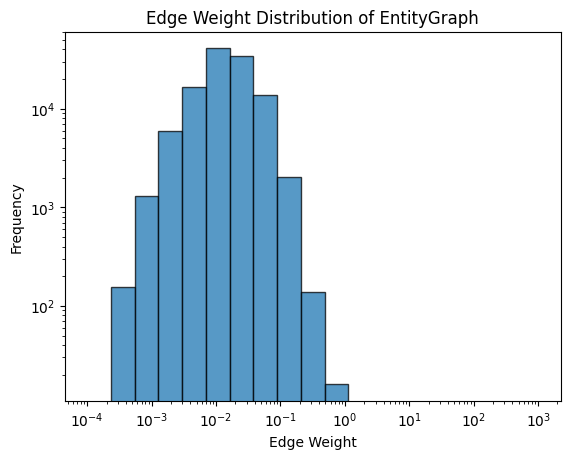

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Degree distribution
degree_sequence = [d for n, d in entityGraph.degree()]
plt.hist(degree_sequence, bins=np.logspace(0, 3, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.title("Degree Distribution of EntityGraph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Edge weight distribution
edge_weight_sequence = [entityGraph[u][v]['weight'] for u, v in entityGraph.edges()]
plt.hist(edge_weight_sequence, bins=np.logspace(-4, 3, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.title("Edge Weight Distribution of EntityGraph")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.show()


- we can observe one peak in the degree distribution at fairly low values, with a fat tail toward large degree values. Also, the edge weight shows a similar behavior, with a peak at rather low values and fat right tails.  
- These distributions suggest **the presence of several small communities, namely cliques, which are connected to each other via some central nodes**  
- The edge weight distribution shown in the preceding graph suggests that a suitable threshold could be 0.05

In [22]:
filteredEntityGraph = entityGraph.edge_subgraph(
 [edge 
 for edge in entityGraph.edges
if entityGraph.edges[edge]["weight"]>0.05])

In [23]:
print("=====FilteredEntityGraph=====")
print("Number of nodes:", filteredEntityGraph.number_of_nodes())
print("Number of edges:", filteredEntityGraph.number_of_edges())
print("Average degree:", sum(dict(filteredEntityGraph.degree()).values()) / filteredEntityGraph.number_of_nodes())

=====FilteredEntityGraph=====
Number of nodes: 1808
Number of edges: 9097
Average degree: 10.063053097345133


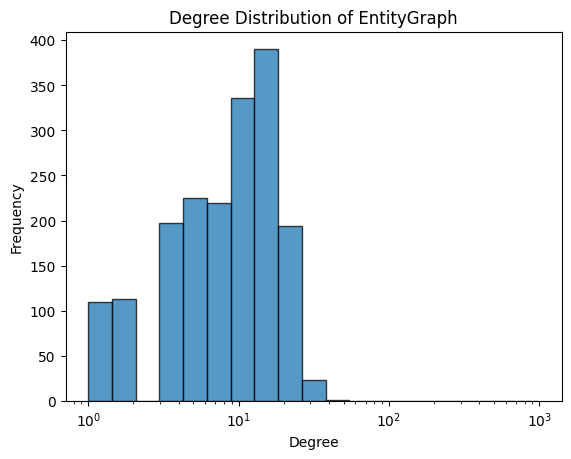

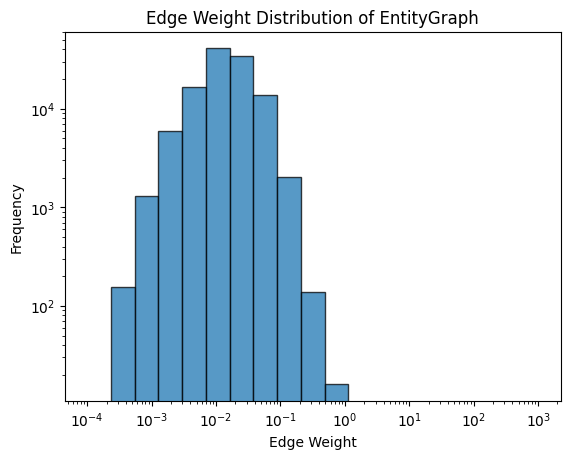

In [24]:
# Degree distribution
degree_sequence = [d for n, d in filteredEntityGraph.degree()]
plt.hist(degree_sequence, bins=np.logspace(0, 3, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.title("Degree Distribution of EntityGraph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Edge weight distribution
edge_weight_sequence = [entityGraph[u][v]['weight'] for u, v in entityGraph.edges()]
plt.hist(edge_weight_sequence, bins=np.logspace(-4, 3, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.title("Edge Weight Distribution of EntityGraph")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.show()

- this is less obvious, and it shows the peak for the nodes that have a degree around 
10, as opposed to the peak shown in above graph which show peak at degree around 100.

In [25]:
# Step 1: Get the connected components
components = nx.connected_components(filteredEntityGraph)
pd.Series([len(c) for c in components])


0    1791
1       4
2       2
3       2
4       3
5       2
6       4
dtype: int64

In [26]:
components = nx.connected_components(filteredEntityGraph)
first_component = next(components)  # Retrieve the first element from the generator
first_component = filteredEntityGraph.subgraph(first_component)

# Now, 'first_component' is a set containing the nodes of the first connected component
print(first_component)


Graph with 1791 nodes and 9085 edges


### **4. Analyst the Graph**

In [27]:
# Step 3: Calculate network metrics for the first connected component
shortest_path = nx.average_shortest_path_length(first_component)
clustering_coefficient = nx.average_clustering(first_component)
global_efficiency = nx.global_efficiency(first_component)

# Step 4: Create a Pandas Series for the metrics
component_metrics = pd.Series({
    "Shortest Path": shortest_path,
    "Clustering Coefficient": clustering_coefficient,
    "Global Efficiency": global_efficiency
})

# Display the calculated metrics
print("Network Metrics for the First Connected Component:")
for metric, value in component_metrics.items():
    print(f"{metric}: {value:.6f}")

Network Metrics for the First Connected Component:
Shortest Path: 3.874338
Clustering Coefficient: 0.215627
Global Efficiency: 0.278468


- On average it take about 3.85 or 4 step to go from one node to another.  
- It is moderate level of local connectivities on (Clustering Coefficient) and  moderate level of efficiency in information flow across the entire network (Global Efficientcy)
- 

[Graph Properties](https://subscription.packtpub.com/book/data/9781800204492/2/ch02lvl1sec06/graph-properties)  
These three measurement measure how efficiently information spread across a network.  
- `The average shortest path or characteristic path length `is defined as the average of all the shortest path lengths between all possible pair of nodes.
- `The clustering coefficient` measures the extent to which nodes in a network tend to cluster together. It ranges from 0 to 1, with higher values indicating a greater tendency for nodes to form local clusters or groups.  
- `Global efficiency` is the average of the inverse shortest path length for all pair of nodes. Such a metric can be seen as a measure of how efficiently information is exchanged across a network.  

In [35]:
# Calculate PageRank
pagerank_values = nx.pagerank(first_component)

# Get degrees
degrees = dict(first_component.degree())

# Get betweenness centralities
betweenness_centralities = nx.betweenness_centrality(first_component)


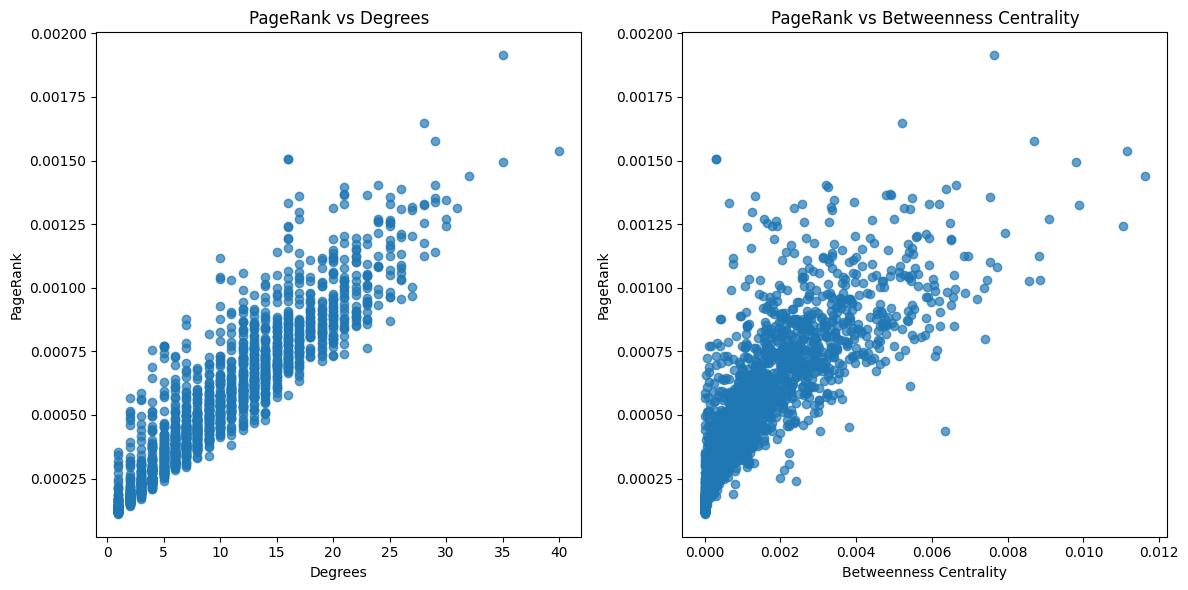

In [29]:


# Plot PageRank vs Degrees
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(list(degrees.values()), list(pagerank_values.values()), alpha=0.7)
plt.title('PageRank vs Degrees')
plt.xlabel('Degrees')
plt.ylabel('PageRank')

# Plot PageRank vs Betweenness Centrality
plt.subplot(1, 2, 2)
plt.scatter(list(betweenness_centralities.values()), list(pagerank_values.values()), alpha=0.7)
plt.title('PageRank vs Betweenness Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('PageRank')

plt.tight_layout()
plt.show()

[Graph Algorithm: Community Detection Algorithm (Louvain)](https://timbr.ai/community-detection-algorithm/#:~:text=The%20Community%20Detection%20algorithm%20is,than%20to%20the%20other%20nodes)  
- `The Community Detection algorithm (Louvain)` is used to detect communities (clusters) in networks (interrelated items) by evaluating how much more densely connected the nodes within a community are, compared to how connected they would be in a random network (i.e., nodes more like each other than to the other nodes)  
- `Community` here refers to the occurrence of groups of nodes in a network that are more densely connected internally than with the rest of the network,


In [30]:
communities=nx.community.louvain_communities(filteredEntityGraph)
# Print the communities
for i, community in enumerate(list(communities)):
    print(f"Community {i + 1}: {community}")

Community 1: {'previously', 'regular'}
Community 2: {'gelco', 'american express', 'care', 'regulatory', 'consider', 'nippon', 'goldman', 'offices', 'utilicorp', 'minerals', 'nippon life', 'brokerage', 'worth', 'taft broadcasting', 'electronics', 'competitive', 'internal', 'institutional', 'reflect', 'outstanding common', 'dudley taft', 'express', 'virginia', 'taft', 'asset', 'positions', 'entertainment', 'iron', 'increased', 'life', 'services', 'shearson', 'high', 'broadcasting', 'growing'}
Community 3: {'problem', 'affect', 'offered', 'barrels', 'usda', 'basic', 'moscow', 'majority', 'richard', 'rep', 'lyng', 'grains', 'mixed', 'juice', 'legislation', 'herrington', 'certificates', 'institutes', 'budget', 'congressional', 'developments', 'democrat', 'reagan', 'controls', 'the soviet union', 'sen', 'rice', 'farm', 'soon', 'shultz', 'algeria', 'grain', 'payment', 'cost', 'competition', 'approved', 'congress', 'review', 'president reagan', 'democratic', 'wheat', 'house', 'republican', 'ee

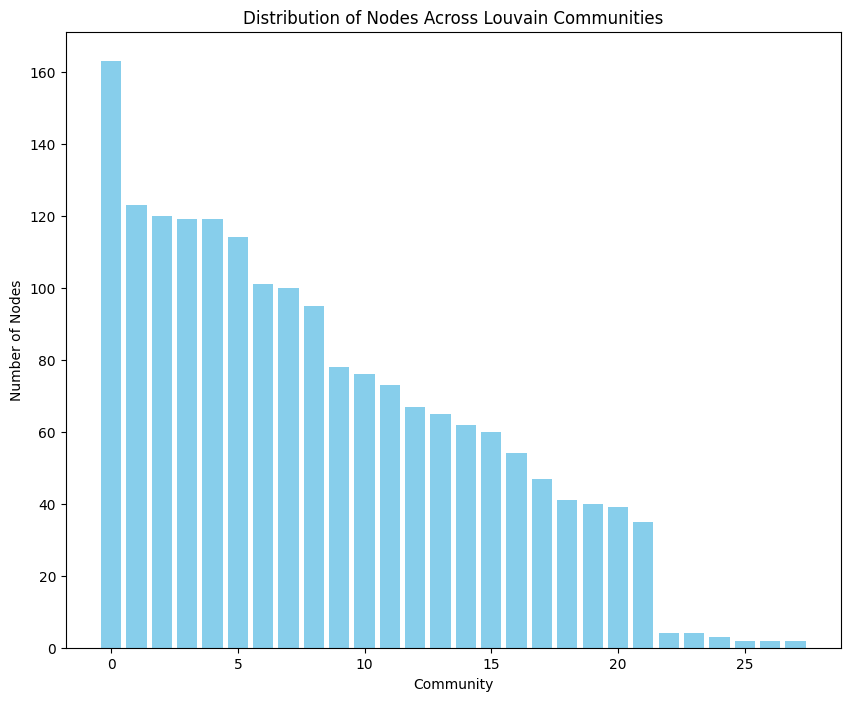

In [31]:
# Calculate the sizes of each community and sort them
sorted_communities = sorted(communities, key=lambda x: len(x), reverse=True)
community_sizes = [len(community) for community in sorted_communities]

# Plot the sorted distribution
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_communities)), community_sizes, color='skyblue')
plt.xlabel('Community')
plt.ylabel('Number of Nodes')
plt.title('Distribution of Nodes Across Louvain Communities')
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_5436\3057907040.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(G1, pos, node_color=community_color, cmap=plt.cm.get_cmap('viridis'), node_size=100)


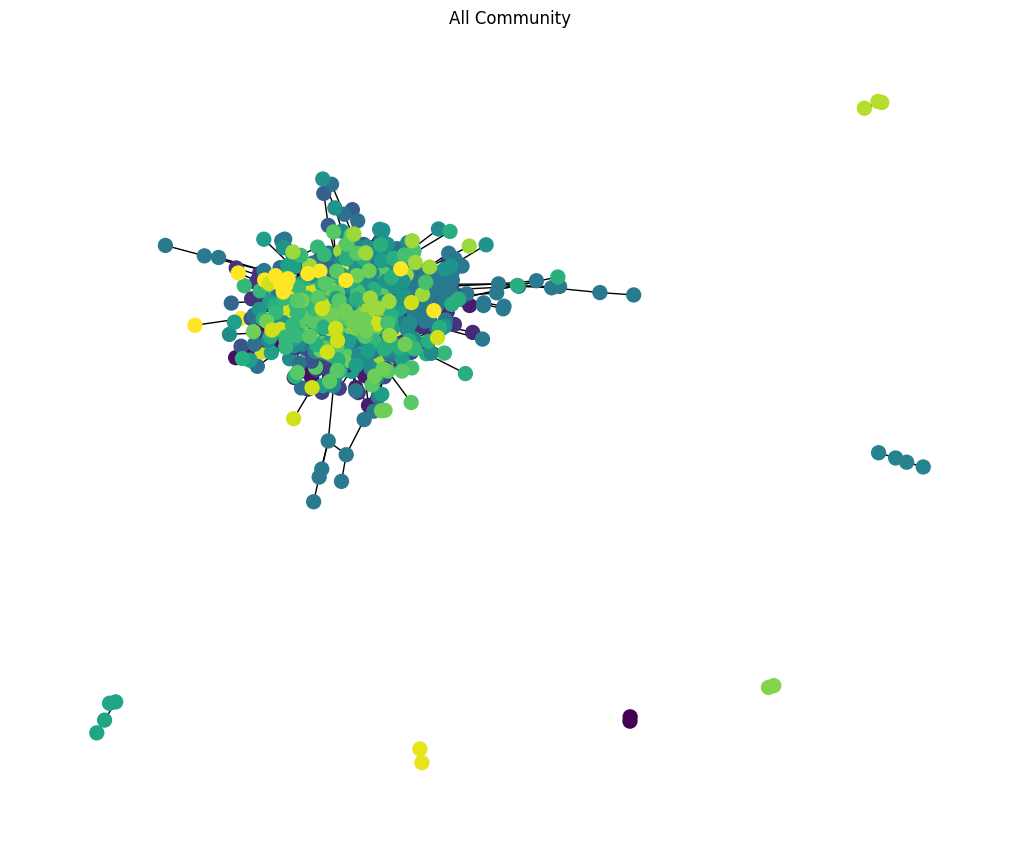

In [32]:
# Create an empty graph
G1 = nx.Graph()

# Add nodes and edges from the Louvain communities
for community_id, community_nodes in enumerate(communities):
    G1.add_nodes_from(community_nodes, community=community_id)
    G1.add_edges_from((node, neighbor) for node in community_nodes for neighbor in filteredEntityGraph.neighbors(node))

# Generate positions for the nodes
pos = nx.spring_layout(G1)

# Extract community information for coloring
community_color = [G1.nodes[node]['community'] for node in G1.nodes]

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G1, pos, node_color=community_color, cmap=plt.cm.get_cmap('viridis'), node_size=100)
plt.title('All Community')
plt.show()

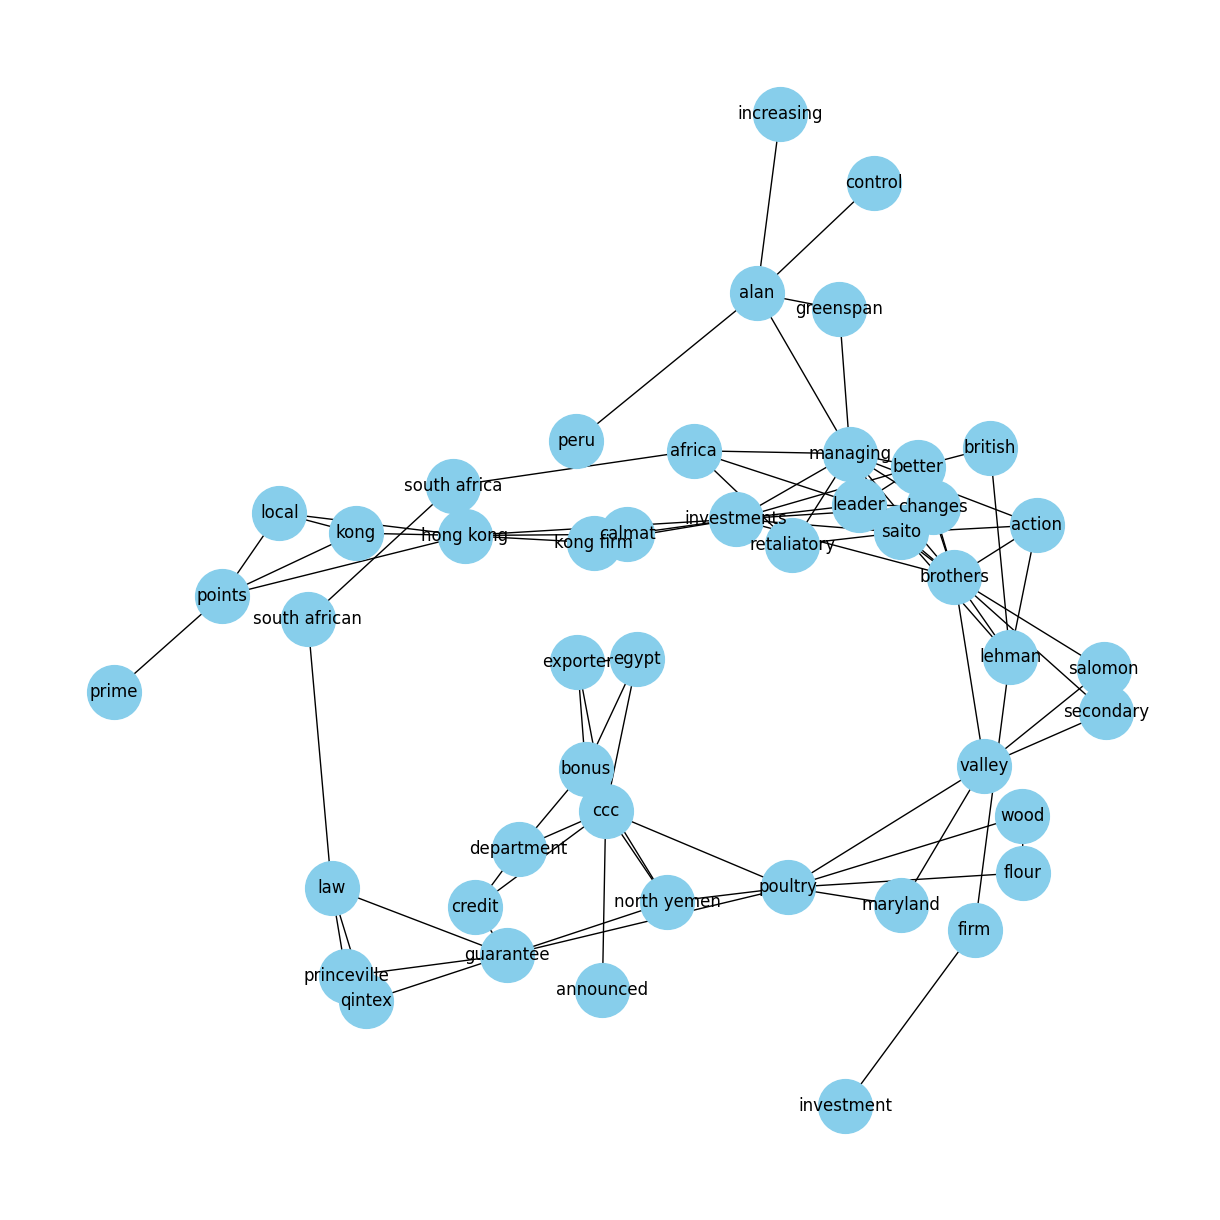

In [62]:
nodes1= communities[27]
smallGrap1 = nx.subgraph(filteredEntityGraph, nbunch=nodes1)
plt.figure(figsize=(12,12))

pos = nx.spring_layout(smallGrap1) # k regulates the distance between nodes

nx.draw(smallGrap1, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)

# plt.show()
# plt.savefig(os.path.join(".", "CloseUp.png"), dpi=300, format="png")

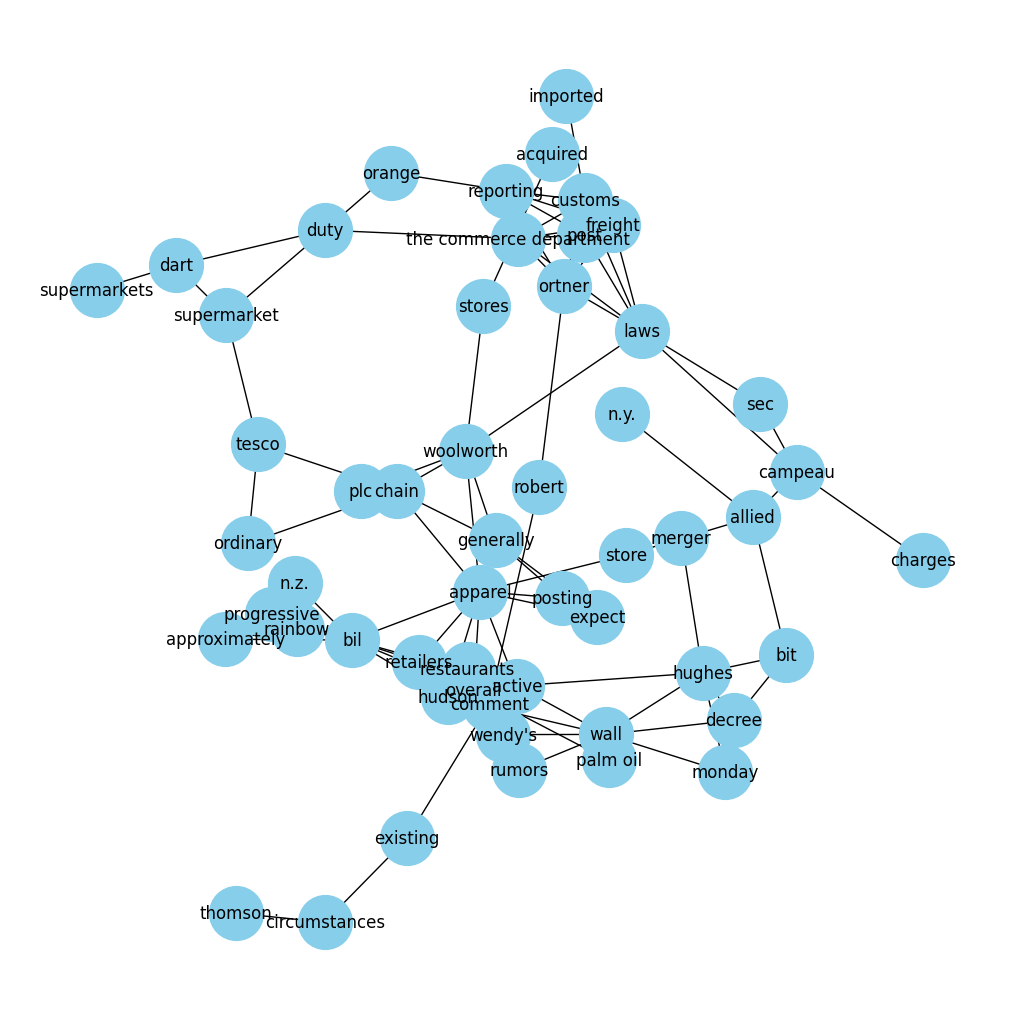

In [38]:
nodes= communities[8]
smallGrap = nx.subgraph(filteredEntityGraph, nbunch=nodes)
plt.figure(figsize=(10,10))

pos = nx.spring_layout(smallGrap) # k regulates the distance between nodes

nx.draw(smallGrap, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)

# plt.show()
# plt.savefig(os.path.join(".", "CloseUp.png"), dpi=300, format="png")

### **Bipartite closeup of the cluster**

In [39]:
bipartiteCloseup = subGraph.edge_subgraph(
    {e for e in subGraph.edges() if len(set(e).intersection(nodes))>0}
)

deg = nx.degree(bipartiteCloseup)

smallGrap = nx.subgraph(bipartiteCloseup, {n for n, d in bipartiteCloseup.nodes(data=True) if d["bipartite"]==1 or deg[n]>1})

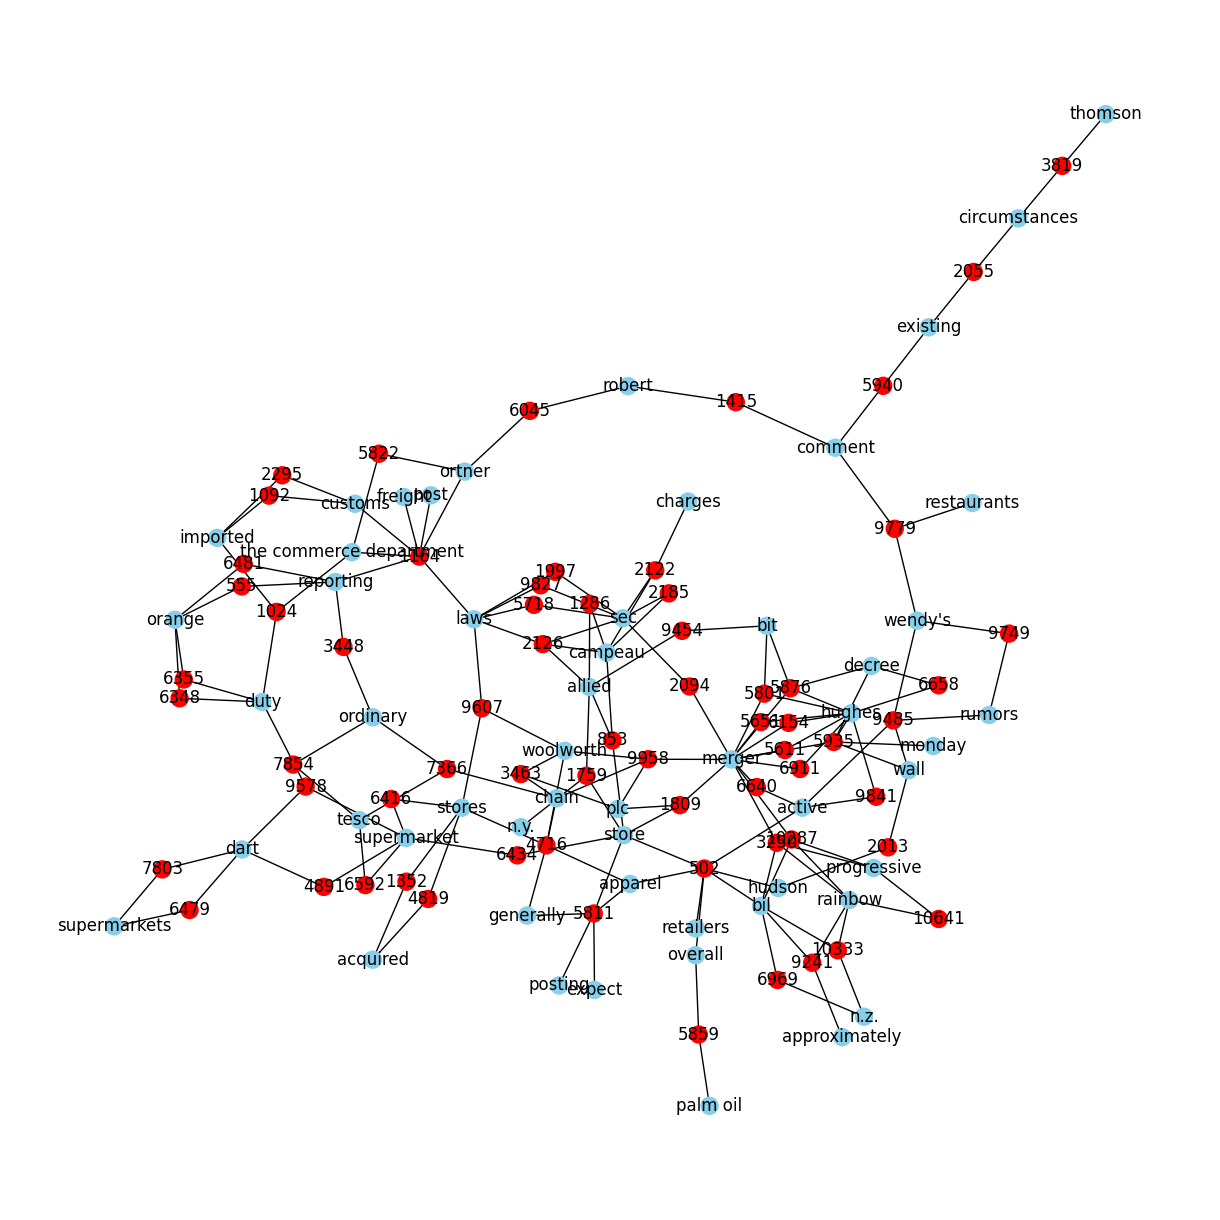

In [42]:
plt.figure(figsize=(12,12))

pos = nx.kamada_kawai_layout(smallGrap) # k regulates the distance between nodes

node_color = ["skyblue" if d["bipartite"]==1 else "red" for n, d in smallGrap.nodes(data=True)]

nx.draw(smallGrap, with_labels=True, node_color=node_color, #'skyblue', 
        node_size=150, edge_cmap=plt.cm.Blues, pos = pos)


# plt.show()
# plt.savefig(os.path.join(".", "BipartiteCloseUp.png"), dpi=300, format="png")

In [34]:
from node2vec import Node2Vec

node2vec = Node2Vec(filteredEntityGraph, dimensions=5, workers=4)  # Use the number of available CPU cores
model = node2vec.fit(window=10)
embeddings = model.wv


c:\Users\Acer\anaconda3\envs\NLP1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing transition probabilities:   0%|          | 0/1808 [00:00<?, ?it/s]

Computing transition probabilities: 100%|██████████| 1808/1808 [00:04<00:00, 394.78it/s]
